#import basic packages

In [ ]:
import functools
import sys
import numpy as np
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import tqdm
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

#Load CIFAR-10 Dataset


In [ ]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)


100%|██████████| 170498071/170498071 [00:02<00:00, 60500596.50it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # 输入是 Z, 对Z进行卷积
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 上采样至 8x8
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 上采样至 16x16
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 上采样至 32x32
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # 输出图像的尺寸是 3x32x32
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 输入图像尺寸是 3x32x32
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 下采样至 16x16
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 下采样至 8x8
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 下采样至 4x4
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # 输出一个单一的数值
        )

    def forward(self, input):
        return self.main(input).view(-1)



In [ ]:
# train the GAN

netG = Generator()
netD = Discriminator()

criterion = nn.BCELoss()
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimize_D = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimize_G = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

netD.to(device)
netG.to(device)

img_list = []

print('start training Loop.....')
for epoch in range(5):
    for i, data in enumerate(trainloader, 0):

        netD.zero_grad()
        # train with real
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimize_D.step()

        # train Generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimize_G.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, 25, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))







start training Loop.....
[0/25][0/782]	Loss_D: 1.5148	Loss_G: 1.3852	D(x): 0.4441	D(G(z)): 0.4888 / 0.2564
[0/25][50/782]	Loss_D: 0.1254	Loss_G: 5.2113	D(x): 0.9178	D(G(z)): 0.0371 / 0.0055
[0/25][100/782]	Loss_D: 0.0831	Loss_G: 5.6147	D(x): 0.9462	D(G(z)): 0.0239 / 0.0038
[0/25][150/782]	Loss_D: 0.0782	Loss_G: 6.1583	D(x): 0.9708	D(G(z)): 0.0460 / 0.0025
[0/25][200/782]	Loss_D: 0.5430	Loss_G: 3.4296	D(x): 0.7991	D(G(z)): 0.2449 / 0.0366
[0/25][250/782]	Loss_D: 0.2670	Loss_G: 3.8313	D(x): 0.8887	D(G(z)): 0.1258 / 0.0239
[0/25][300/782]	Loss_D: 1.8406	Loss_G: 2.7902	D(x): 0.2408	D(G(z)): 0.0102 / 0.0723
[0/25][350/782]	Loss_D: 0.8082	Loss_G: 2.1803	D(x): 0.5392	D(G(z)): 0.0952 / 0.1344
[0/25][400/782]	Loss_D: 0.6204	Loss_G: 2.2654	D(x): 0.7246	D(G(z)): 0.2104 / 0.1410
[0/25][450/782]	Loss_D: 1.2642	Loss_G: 2.1523	D(x): 0.5013	D(G(z)): 0.3142 / 0.1933
[0/25][500/782]	Loss_D: 0.8008	Loss_G: 2.2182	D(x): 0.7297	D(G(z)): 0.3296 / 0.1323
[0/25][550/782]	Loss_D: 0.8383	Loss_G: 4.1123	D(x): 0.

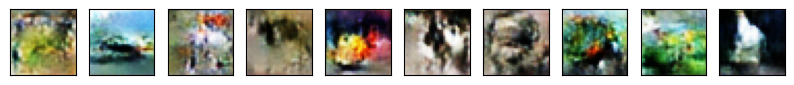

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch



n_classes = 10 # CIFAR-10的类别数
n_examples = 1 # 每个类别生成图片的数量

# 生成条件噪声向量
fixed_noise = torch.randn(n_classes * n_examples, 100, 1, 1, device=device) # noise dimension 100

# 为每个类别生成标签
labels = torch.arange(n_classes).repeat(n_examples)

# 生成图片
with torch.no_grad():
    netG.eval()
    # 假设你的生成器接受标签作为条件输入
    # 这里需要根据你的具体实现来调整
    fake_images = netG(fixed_noise).detach().cpu()

import matplotlib.pyplot as plt
import numpy as np

# 假定 fake_images, n_classes, n_examples 已经定义

fig = plt.figure(figsize=(10, 10))
for i in range(n_classes * n_examples):
    img = fake_images[i] / 2 + 0.5 # 反归一化
    npimg = img.numpy()
    # 交换行列参数以横向展示图像
    ax = fig.add_subplot(n_examples, n_classes, i + 1, xticks=[], yticks=[])
    npimg = np.transpose(npimg, (1, 2, 0)) # 调整通道顺序
    ax.imshow(npimg)
    # 如果你想给每个图像添加标签
    # 假设 labels 是一个与 fake_images 匹配的标签列表
    # class_per_row = i % n_classes
    # ax.set_title(f"Class {labels[class_per_row].item()}")

plt.show()

